## Задача проекта:
Нужно выделить пользователей, которые готовы совершить покупку в ближайшее время и предсказать вероятность покупки в течение 90 дней


## Описание данных

Таблица `apparel-purchases` с историей покупок

`client_id` - идентификатор пользователя

`quantity` - количество товаров в заказе

`price` - цена товара

`category_ids` - вложенные категории, к которым отнсится товар

`date` - дата покупки

`message_id` - идентификатор сообщения из рассылки <br><br>

Таблица `apparel-messages` с ситорией рекламных рассылок

`bulk_campaign_id` - идентификатор рекламной кампании

`client_id` - идентификатор пользователя

`message_id` - идентификатор сообщений

`event` - тип действия

`channel` - канал рассылки

`date` - дата рассылки

`created_at` - точное время создания сообщения <br><br>

Таблица `apparel-target_binary` с информацией о том совершит ли клиент покупку в течение следующих 90 дней

`client_id` - идентификатор пользователя

`target` - целевой признак

## Импорт библиотек и загрузка данных

In [50]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import ast



import matplotlib.pyplot as plt
import seaborn as sns


# загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline              
from sklearn.compose import ColumnTransformer

#классы для обработки данных для модели
from sklearn.preprocessing import OneHotEncoder, RobustScaler
#модели

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  RandomizedSearchCV, train_test_split

from sklearn.metrics import roc_auc_score

import shap


In [2]:
messages = pd.read_csv('C:/Users/Ke/Masterskaya2/apparel-messages.csv')
purchases = pd.read_csv('C:/Users/Ke/Masterskaya2/apparel-purchases.csv')
target =  pd.read_csv('C:/Users/Ke/Masterskaya2/apparel-target_binary.csv')

In [3]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


## Создание новых признаков

Преобразуем датафрейм messages. Посчитаем количество уникальных событий из столбца event для каждого клиента

In [5]:
e = messages.groupby(['client_id'])['event'].value_counts()
e = e.to_frame()
e.reset_index(inplace=True)
e.set_index('client_id')
e

,client_id,event,count
0,1515915625468060902,send,126
1,1515915625468060902,open,35
2,1515915625468060902,click,10
3,1515915625468060902,purchase,5
4,1515915625468060902,unsubscribe,1
...,...,...,...
206129,1515915626010261344,click,1
206130,1515915626010261344,open,1
206131,1515915626010261344,send,1
206132,1515915626010288690,open,1


Теперь развернем столбец event, сделаем каждое событие признаком.

In [6]:
e = e.pivot_table(index='client_id', columns='event', values='count')
e

event,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
client_id,,,,,,,,,,,
1515915625468060902,10.0,NaN,NaN,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0
1515915625468061003,6.0,NaN,NaN,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN
1515915625468061099,8.0,NaN,NaN,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN
1515915625468061100,1.0,NaN,NaN,1.0,NaN,163.0,1.0,267.0,1.0,NaN,NaN
1515915625468061170,16.0,NaN,NaN,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1515915626010183608,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
1515915626010221592,3.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
1515915626010234726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [7]:
e.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   click        48060 non-null  float64
 1   close        1 non-null      float64
 2   complain     281 non-null    float64
 3   hard_bounce  12752 non-null  float64
 4   hbq_spam     806 non-null    float64
 5   open         44710 non-null  float64
 6   purchase     42055 non-null  float64
 7   send         53303 non-null  float64
 8   soft_bounce  1882 non-null   float64
 9   subscribe    75 non-null     float64
 10  unsubscribe  2209 non-null   float64
dtypes: float64(11)
memory usage: 4.9 MB


Удалим из таблицы наименее информативные столбцы, в которых очень много пропущенных значений, в оставшихся данных заполним пропуски.

In [8]:
e = e.drop(['close', 'subscribe'], axis=1)
e = e.fillna(0)
e

event,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,unsubscribe
client_id,,,,,,,,,
1515915625468060902,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,1.0
1515915625468061003,6.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0
1515915625468061099,8.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0
1515915625468061100,1.0,0.0,1.0,0.0,163.0,1.0,267.0,1.0,0.0
1515915625468061170,16.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1515915626010183608,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
1515915626010221592,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
1515915626010234726,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Сделаем client_id снова признаком, а не индексом

In [9]:
e.reset_index(inplace=True)
e.head(10)

event,client_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,1.0
1,1515915625468061003,6.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0
2,1515915625468061099,8.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0
3,1515915625468061100,1.0,0.0,1.0,0.0,163.0,1.0,267.0,1.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0
5,1515915625468061514,12.0,0.0,0.0,0.0,17.0,1.0,150.0,0.0,0.0
6,1515915625468061877,5.0,0.0,0.0,0.0,50.0,1.0,173.0,0.0,0.0
7,1515915625468061899,3.0,0.0,0.0,0.0,15.0,0.0,111.0,0.0,0.0
8,1515915625468061975,7.0,0.0,0.0,1.0,17.0,1.0,154.0,0.0,0.0
9,1515915625468061994,11.0,0.0,0.0,0.0,21.0,2.0,346.0,0.0,0.0


In [10]:
e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    53329 non-null  int64  
 1   click        53329 non-null  float64
 2   complain     53329 non-null  float64
 3   hard_bounce  53329 non-null  float64
 4   hbq_spam     53329 non-null  float64
 5   open         53329 non-null  float64
 6   purchase     53329 non-null  float64
 7   send         53329 non-null  float64
 8   soft_bounce  53329 non-null  float64
 9   unsubscribe  53329 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 4.1 MB


Теперь преобразуем датафрейм с чеками

In [11]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [12]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Выделим признак наиболее часто покупаемой категории. Для начала сгруппируем данные по client_id	и category_ids и посчитаем сколько раз пользователь покупал товары из той или иной категории.

In [13]:
pu = purchases.groupby(['client_id'])['category_ids'].value_counts()
pu = pu.to_frame()
pu.reset_index(inplace=True)
pu.head(10)

,client_id,category_ids,count
0,1515915625468060902,"['4', '27', '176', '458']",2
1,1515915625468060902,"['4', '28', '260', '420']",2
2,1515915625468060902,"['4', '27', '1828', '1599']",1
3,1515915625468060902,"['4', '28', '244', '432']",1
4,1515915625468060902,"['4', '28', '290', '422']",1
5,1515915625468061003,"['4', '28', '249', '615']",7
6,1515915625468061099,"['4', '28', '290', '424']",1
7,1515915625468061100,"['4', '27', '1828', '5717']",2
8,1515915625468061170,"['4', '28', '260', '420']",12
9,1515915625468061170,"['4', '28', '244', '432']",3


Т.к. первые два числа в category_ids часто повторяются у разных людей, то более общая категория будет информативнее, нежели использовать полную категорию.

In [14]:
# Преобразуем строковые представления списков в настоящие списки
pu['category_ids'] = pu['category_ids'].apply(ast.literal_eval)

In [15]:
# Применяем функцию к столбцу и создаем новый столбец
pu['general_category'] = pu['category_ids'].apply(lambda x: x[:2])
pu.head()

,client_id,category_ids,count,general_category
0,1515915625468060902,"[4, 27, 176, 458]",2,"[4, 27]"
1,1515915625468060902,"[4, 28, 260, 420]",2,"[4, 28]"
2,1515915625468060902,"[4, 27, 1828, 1599]",1,"[4, 27]"
3,1515915625468060902,"[4, 28, 244, 432]",1,"[4, 28]"
4,1515915625468060902,"[4, 28, 290, 422]",1,"[4, 28]"


In [16]:
pu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93733 entries, 0 to 93732
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         93733 non-null  int64 
 1   category_ids      93733 non-null  object
 2   count             93733 non-null  int64 
 3   general_category  93733 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [17]:
pu['general_category'] = pu['general_category'].apply(lambda x: ', '.join(map(str, x)))

# Оставляем только нужные столбцы
pu = pu[['client_id', 'general_category']]
pu.head()

,client_id,general_category
0,1515915625468060902,"4, 27"
1,1515915625468060902,"4, 28"
2,1515915625468060902,"4, 27"
3,1515915625468060902,"4, 28"
4,1515915625468060902,"4, 28"


In [18]:
pu.head(10)

,client_id,general_category
0,1515915625468060902,"4, 27"
1,1515915625468060902,"4, 28"
2,1515915625468060902,"4, 27"
3,1515915625468060902,"4, 28"
4,1515915625468060902,"4, 28"
5,1515915625468061003,"4, 28"
6,1515915625468061099,"4, 28"
7,1515915625468061100,"4, 27"
8,1515915625468061170,"4, 28"
9,1515915625468061170,"4, 28"


In [19]:
pu = pu.groupby(['client_id'])['general_category'].value_counts()
pu = pu.to_frame()
pu.reset_index(inplace=True)
pu.head(10)

,client_id,general_category,count
0,1515915625468060902,"4, 28",3
1,1515915625468060902,"4, 27",2
2,1515915625468061003,"4, 28",1
3,1515915625468061099,"4, 28",1
4,1515915625468061100,"4, 27",1
5,1515915625468061170,"4, 28",2
6,1515915625468061170,,1
7,1515915625468061170,"2, 18",1
8,1515915625468061514,"4, 28",1
9,1515915625468061877,"5562, 5630",1


In [20]:
# Группируем по client_id, находим индекс строки с максимальным count
idx = pu.groupby('client_id')['count'].idxmax()

# Получаем новый DataFrame с нужными строками
pu = pu.loc[idx].reset_index(drop=True)
pu.head()

,client_id,general_category,count
0,1515915625468060902,"4, 28",3
1,1515915625468061003,"4, 28",1
2,1515915625468061099,"4, 28",1
3,1515915625468061100,"4, 27",1
4,1515915625468061170,"4, 28",2


In [21]:
pu = pu[['client_id', 'general_category']].rename(columns={'general_category': 'favorite_category'})
pu.head(20)

,client_id,favorite_category
0,1515915625468060902,"4, 28"
1,1515915625468061003,"4, 28"
2,1515915625468061099,"4, 28"
3,1515915625468061100,"4, 27"
4,1515915625468061170,"4, 28"
5,1515915625468061514,"4, 28"
6,1515915625468061877,"5562, 5630"
7,1515915625468061975,"4, 5837"
8,1515915625468061994,"6060, 6058"
9,1515915625468062158,"4, 28"


In [22]:
pu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_id          49849 non-null  int64 
 1   favorite_category  49849 non-null  object
dtypes: int64(1), object(1)
memory usage: 779.0+ KB


In [23]:
print(f"Было: {len(purchases['category_ids'].unique())} категории")
print(f"Стало: {len(pu['favorite_category'].unique())} категории")

Было: 933 категории
Стало: 29 категории


Заметно сократили число категорий, что должно хорошо сказаться на модели

In [24]:
pur = pd.pivot_table(purchases, index='client_id', values='price', aggfunc=['count', 'mean'])
pur.columns = pur.columns.droplevel(1)
pur.reset_index(inplace=True)

In [25]:
pur.head(10)

,client_id,count,mean
0,1515915625468060902,7,999.000000
1,1515915625468061003,7,2319.285714
2,1515915625468061099,1,299.000000
3,1515915625468061100,2,1049.000000
4,1515915625468061170,19,1768.473684
5,1515915625468061514,1,999.000000
6,1515915625468061877,1,1499.000000
7,1515915625468061975,1,299.000000
8,1515915625468061994,8,126.500000
9,1515915625468062158,4,1524.000000


In [26]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [27]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [28]:
target['client_id'].nunique()

49849

In [29]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Объединяем все данные в один дф

In [30]:
df = target.merge(e, how='left')
df

,client_id,target,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,unsubscribe
0,1515915625468060902,0,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,1.0
1,1515915625468061003,1,6.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0
2,1515915625468061099,0,8.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0
3,1515915625468061100,0,1.0,0.0,1.0,0.0,163.0,1.0,267.0,1.0,0.0
4,1515915625468061170,0,16.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
49845,1515915626010266132,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    49849 non-null  int64  
 1   target       49849 non-null  int64  
 2   click        41982 non-null  float64
 3   complain     41982 non-null  float64
 4   hard_bounce  41982 non-null  float64
 5   hbq_spam     41982 non-null  float64
 6   open         41982 non-null  float64
 7   purchase     41982 non-null  float64
 8   send         41982 non-null  float64
 9   soft_bounce  41982 non-null  float64
 10  unsubscribe  41982 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.2 MB


In [32]:
#df = df.fillna(0)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    49849 non-null  int64  
 1   target       49849 non-null  int64  
 2   click        41982 non-null  float64
 3   complain     41982 non-null  float64
 4   hard_bounce  41982 non-null  float64
 5   hbq_spam     41982 non-null  float64
 6   open         41982 non-null  float64
 7   purchase     41982 non-null  float64
 8   send         41982 non-null  float64
 9   soft_bounce  41982 non-null  float64
 10  unsubscribe  41982 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.2 MB


In [34]:
df = df.merge(pur)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    49849 non-null  int64  
 1   target       49849 non-null  int64  
 2   click        41982 non-null  float64
 3   complain     41982 non-null  float64
 4   hard_bounce  41982 non-null  float64
 5   hbq_spam     41982 non-null  float64
 6   open         41982 non-null  float64
 7   purchase     41982 non-null  float64
 8   send         41982 non-null  float64
 9   soft_bounce  41982 non-null  float64
 10  unsubscribe  41982 non-null  float64
 11  count        49849 non-null  int64  
 12  mean         49849 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 4.9 MB


In [36]:
df = df.merge(pu)

In [37]:
df

,client_id,target,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,unsubscribe,count,mean,favorite_category
0,1515915625468060902,0,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,1.0,7,999.000000,"4, 28"
1,1515915625468061003,1,6.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,7,2319.285714,"4, 28"
2,1515915625468061099,0,8.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,1,299.000000,"4, 28"
3,1515915625468061100,0,1.0,0.0,1.0,0.0,163.0,1.0,267.0,1.0,0.0,2,1049.000000,"4, 27"
4,1515915625468061170,0,16.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,19,1768.473684,"4, 28"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6,1499.000000,"2, 18"
49845,1515915626010266132,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,909.000000,"4, 27"
49846,1515915626010439406,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,99.000000,"4, 27"
49847,1515915626010443527,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1999.000000,"2, 18"


In [38]:
df.describe()

,client_id,target,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,unsubscribe,count,mean
count,4.984900e+04,49849.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,49849.000000,49849.000000
mean,1.515916e+18,0.019278,10.852318,0.011815,0.392454,0.018103,59.772450,1.371731,188.152470,0.212377,0.062455,4.056410,1483.415229
std,1.487947e+08,0.137503,14.164661,0.489769,0.972551,0.136154,74.921588,1.437177,104.649185,2.943261,0.315328,5.521669,1388.178005
min,1.515916e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.515916e+18,0.000000,3.000000,0.000000,0.000000,0.000000,4.000000,1.000000,115.000000,0.000000,0.000000,1.000000,699.000000
50%,1.515916e+18,0.000000,6.000000,0.000000,0.000000,0.000000,26.000000,1.000000,175.000000,0.000000,0.000000,2.000000,1249.000000
75%,1.515916e+18,0.000000,14.000000,0.000000,1.000000,0.000000,94.000000,2.000000,260.000000,0.000000,0.000000,5.000000,1999.000000
max,1.515916e+18,1.000000,384.000000,80.000000,49.000000,2.000000,1268.000000,103.000000,2473.000000,133.000000,8.000000,346.000000,53499.000000


In [39]:
df_drop =  df.dropna()
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41982 entries, 0 to 49844
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          41982 non-null  int64  
 1   target             41982 non-null  int64  
 2   click              41982 non-null  float64
 3   complain           41982 non-null  float64
 4   hard_bounce        41982 non-null  float64
 5   hbq_spam           41982 non-null  float64
 6   open               41982 non-null  float64
 7   purchase           41982 non-null  float64
 8   send               41982 non-null  float64
 9   soft_bounce        41982 non-null  float64
 10  unsubscribe        41982 non-null  float64
 11  count              41982 non-null  int64  
 12  mean               41982 non-null  float64
 13  favorite_category  41982 non-null  object 
dtypes: float64(10), int64(3), object(1)
memory usage: 4.8+ MB


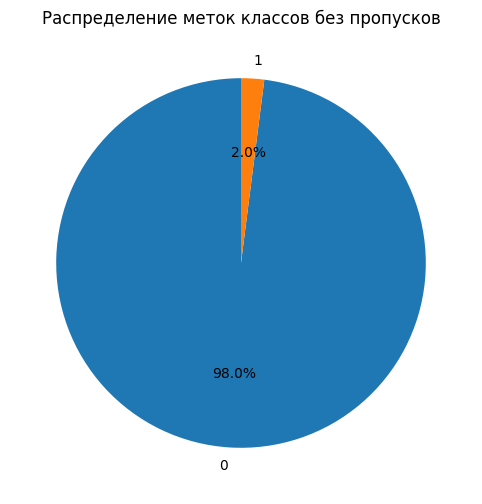

In [40]:
counts = df_drop['target'].value_counts()
plt.figure(figsize=(8, 6))  # Установка размера графика
counts.plot.pie(autopct='%1.1f%%', startangle=90)  # autopct отображает процент, startangle задает угол начала
plt.title('Распределение меток классов без пропусков')  # Заголовок диаграммы
plt.ylabel('')  # Убираем подпись y-оси
plt.show()  # Отображаем график

В данных очень сильный дисбаланс

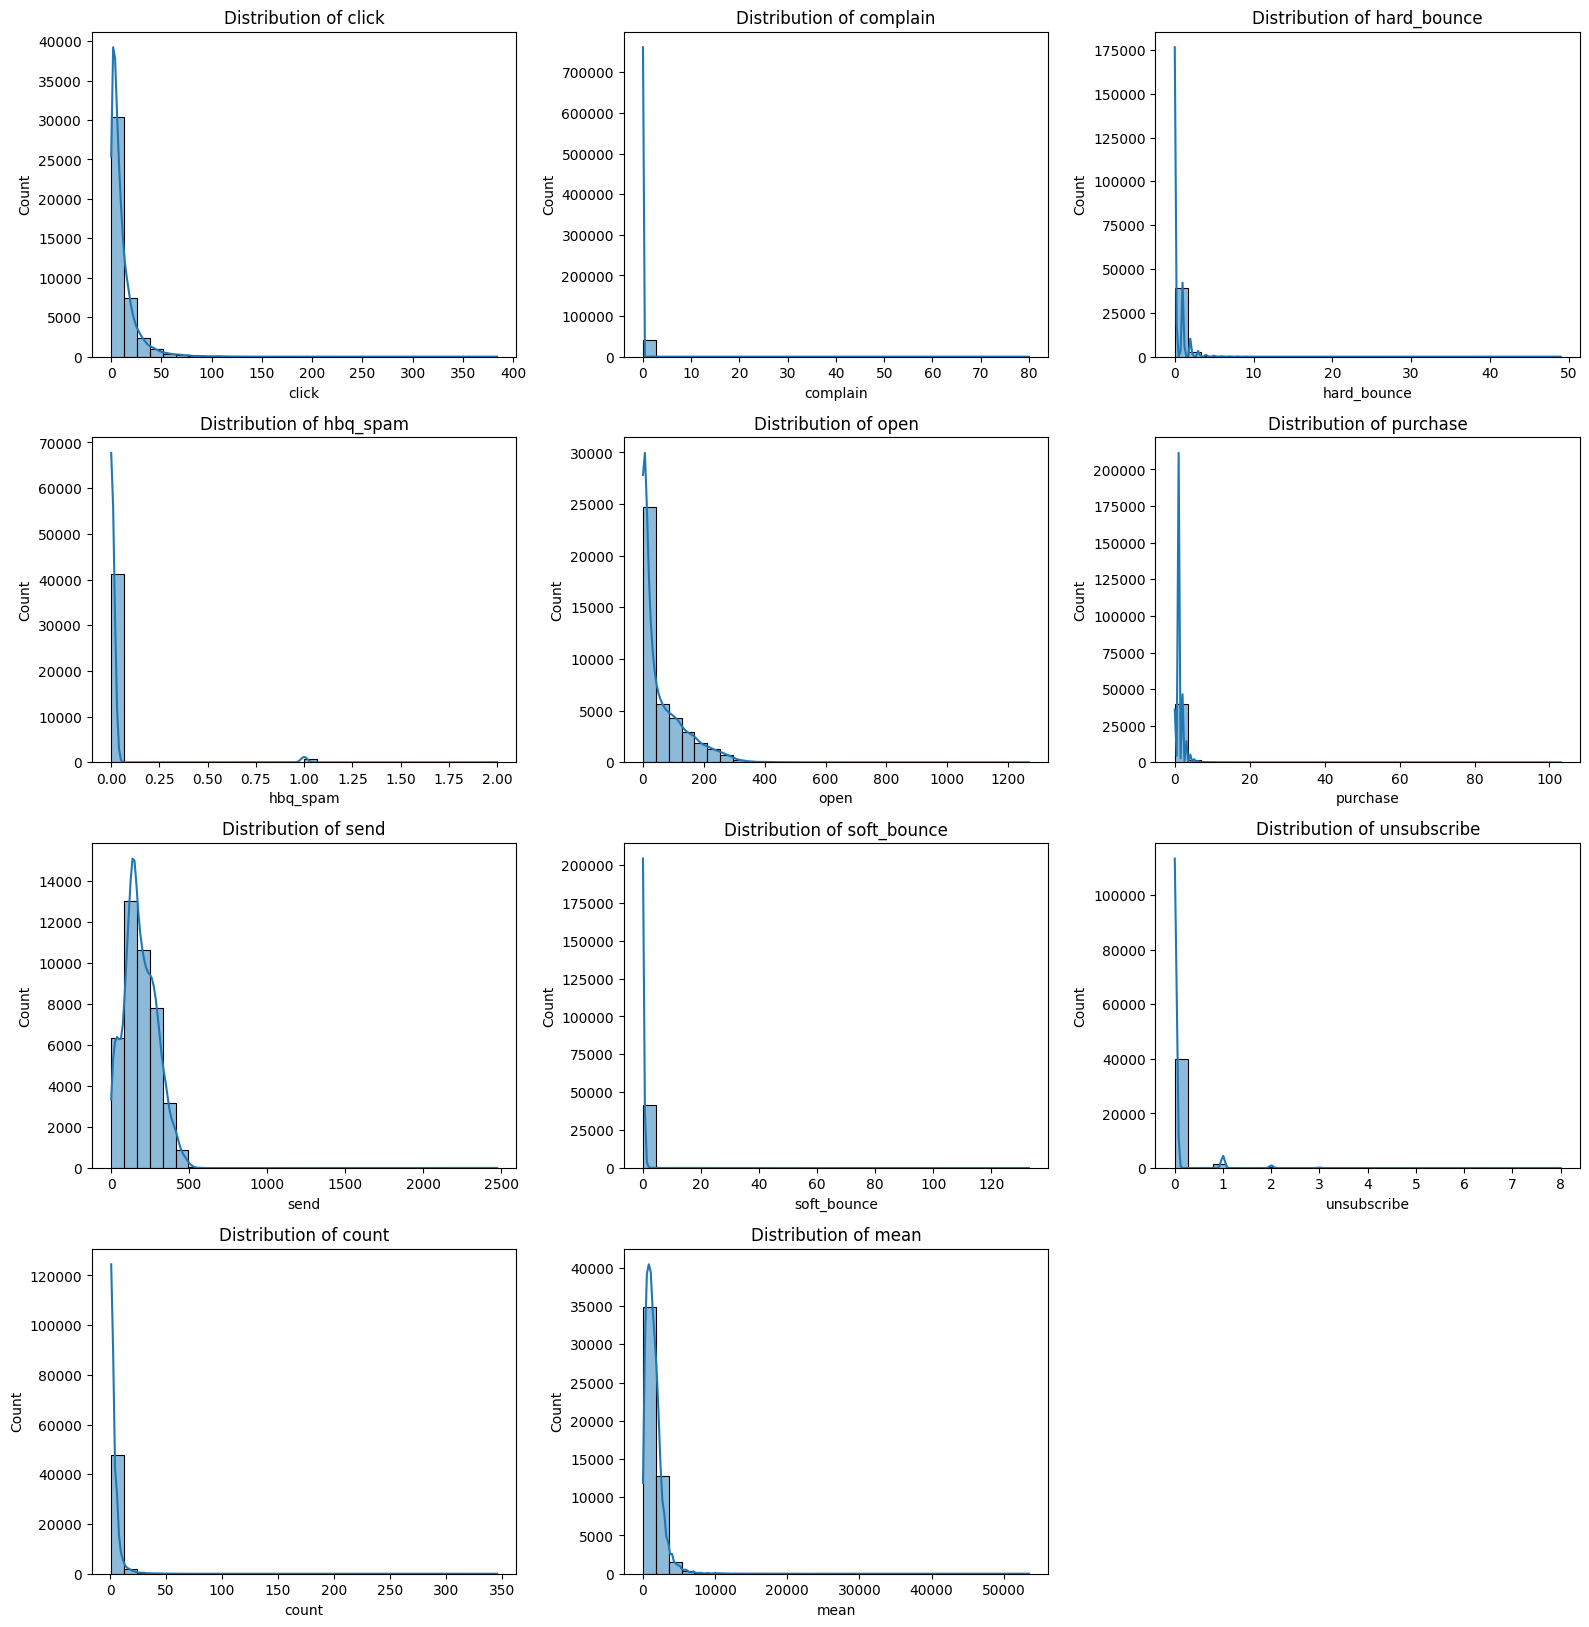

In [41]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop(['client_id', 'target'])

plt.figure(figsize=(16, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Данные распределены со смещением влево, большинство из них нулевые. При мастабировании признаков будем использовать RobustScaler, чтобы избежать сильного влияния выбросов и  не нормального распределения.

## Обучение моделей

Обучим такие модели классификации как случайный лес и kNN

In [44]:
RANDOM_STATE = 777
X = df_drop.drop(['target', 'client_id'], axis=1)
y=df_drop['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
cat_features= ['favorite_category']
num_columns = X.columns.values.tolist()
num_columns.remove('favorite_category')

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_features),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
    ]
)
        

#гиперпараметры для моделей + перебор методов масштабирования




param_grid = [

    
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(50, 10000, 1000),
         'models__weights' : ['uniform', 'distance'],
         'models__p' : [1, 2]
         
    },

    {
        'models' : [RandomForestClassifier(random_state=RANDOM_STATE)]        
    }
]


In [45]:
gridsearch = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
gridsearch.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gridsearch.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', gridsearch.best_score_)
gridsearch.best_params_

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['favorite_category']),
                                                 ('num', RobustScaler(),
                                                  ['click', 'complain',
                     

{'models__weights': 'distance',
 'models__p': 1,
 'models__n_neighbors': 4050,
 'models': KNeighborsClassifier()}

In [46]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__weights,param_models__p,param_models__n_neighbors,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.047094,0.002561,19.756373,1.271501,distance,1.0,4050.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 1...",0.697956,0.683625,0.742028,0.741374,0.667239,0.706444,0.030384,1
4,0.044884,0.005927,13.957947,1.523990,distance,1.0,2050.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 1...",0.688617,0.684806,0.737306,0.740730,0.670528,0.704398,0.028924,2
0,0.051063,0.011654,16.442723,0.534846,uniform,1.0,4050.0,KNeighborsClassifier(),"{'models__weights': 'uniform', 'models__p': 1,...",0.696630,0.682792,0.738518,0.736270,0.663299,0.703502,0.029639,3
8,0.040393,0.003396,13.067532,0.164116,uniform,1.0,3050.0,KNeighborsClassifier(),"{'models__weights': 'uniform', 'models__p': 1,...",0.694645,0.682093,0.746051,0.728229,0.659754,0.702154,0.031188,4
3,0.038696,0.002475,7.970518,0.135132,distance,2.0,2050.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 2...",0.682143,0.675602,0.729662,0.730700,0.661060,0.695833,0.028865,5
1,0.051564,0.011737,24.744991,1.644144,distance,2.0,8050.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 2...",0.689663,0.670214,0.730836,0.724861,0.661403,0.695396,0.028095,6
5,0.043585,0.007008,24.185469,1.578171,distance,2.0,7050.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 2...",0.690989,0.667964,0.731857,0.722749,0.661748,0.695062,0.028218,7
9,0.041688,0.004251,20.187341,1.122170,uniform,2.0,7050.0,KNeighborsClassifier(),"{'models__weights': 'uniform', 'models__p': 2,...",0.690014,0.667764,0.728960,0.717517,0.659633,0.692778,0.027030,8
2,3.050711,0.103235,0.118488,0.016289,NaN,NaN,NaN,RandomForestClassifier(random_state=777),{'models': RandomForestClassifier(random_state...,0.650152,0.644787,0.641790,0.671694,0.667953,0.655275,0.012234,9
7,0.046376,0.014411,1.238420,0.023020,distance,2.0,50.0,KNeighborsClassifier(),"{'models__weights': 'distance', 'models__p': 2...",0.623687,0.588606,0.631025,0.658273,0.619055,0.624129,0.022366,10


Попробуем использовать модель CatBoostClassifier

In [47]:

data_preprocessor = ColumnTransformer(
    [
        ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier())
    ]
)

param_grid = [


{
        'models': [CatBoostClassifier(verbose=400, auto_class_weights='Balanced')],
        'models__loss_function' : ["Logloss"],
        'models__early_stopping_rounds' :[20],
        'models__l2_leaf_reg' : [20],
        'models__depth': range(3, 8),
        'models__learning_rate': [0.001, 0.003],
        'models__iterations': [4000],
        'models__cat_features': [np.array([X_train.columns.get_loc(col) for col in cat_features])],
        
}
]



In [48]:
gridsearch = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
gridsearch.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gridsearch.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', gridsearch.best_score_)
gridsearch.best_params_

0:	learn: 0.6928838	total: 166ms	remaining: 11m 1s
400:	learn: 0.6403239	total: 8.16s	remaining: 1m 13s
800:	learn: 0.6235812	total: 17.2s	remaining: 1m 8s
1200:	learn: 0.6147086	total: 26.9s	remaining: 1m 2s
1600:	learn: 0.6089549	total: 35.4s	remaining: 53s
2000:	learn: 0.6044261	total: 41.8s	remaining: 41.8s
2400:	learn: 0.6005303	total: 48.5s	remaining: 32.3s
2800:	learn: 0.5973708	total: 55.6s	remaining: 23.8s
3200:	learn: 0.5937805	total: 1m 2s	remaining: 15.6s
3600:	learn: 0.5892294	total: 1m 8s	remaining: 7.64s
3999:	learn: 0.5827031	total: 1m 15s	remaining: 0us
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['click', 'complain',
                                                   'hard_bounce', 'hbq_spam',
                                                   'open', 'purchase', 'sen

{'models__loss_function': 'Logloss',
 'models__learning_rate': 0.003,
 'models__l2_leaf_reg': 20,
 'models__iterations': 4000,
 'models__early_stopping_rounds': 20,
 'models__depth': 3,
 'models__cat_features': array([11]),
 'models': <catboost.core.CatBoostClassifier at 0x2700beaeb60>}

## Анализ результатов

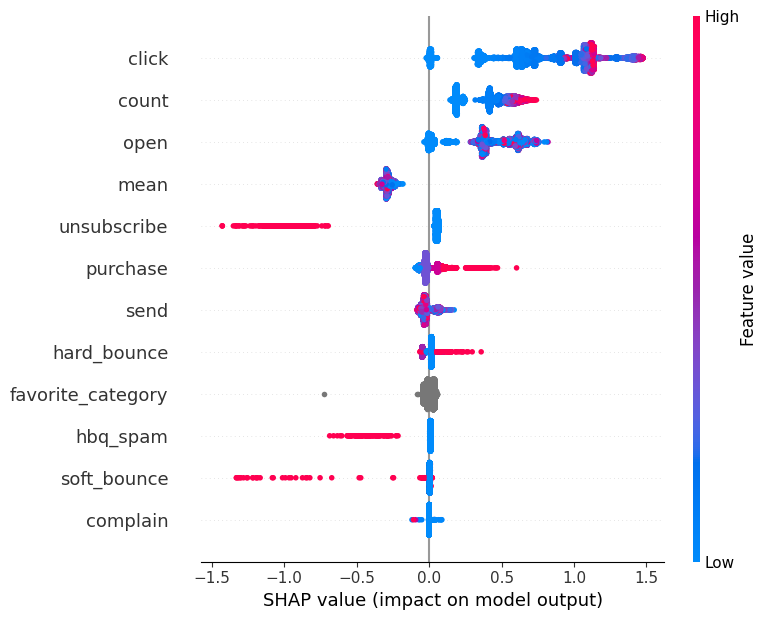

In [51]:
# Создаем объяснитель SHAP значений
explainer = shap.TreeExplainer(gridsearch.best_estimator_.named_steps['models'])

# Рассчитываем SHAP значения для тестовой выборки
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)

1. клики показывают заинтересованность пользователя и соответсвенно предласполагают его совершить покупку
2. пользователи которые ранее неоднократно приобретали товары, с большой вероятностью предолжат совершать покупки в этом же магазине
3. открытие уведомлений и писем повышают вероятность вернуться в магазин.
4. влияние среднего чека оценить сложно
5. если человек отписался от рассылки, то скорее всего больше не вернется.
6. hard_bounce в основном влияет положительно на покупки в будущем
7. письма помеченные спамом отталкивает пользователей от покупок.

## Вывод:
- загрузили данные
- создали признаки на основе событий из таблицы с рекламными коммуникациями
- создали признаки основанные на количестве покупок и средней цены чека
- разбили категории на более общие группы  и на основе этого выделили любимую категорию товаров
- посмотрели на распределение признаков: целевой признак имеет сильный дисбаланс, данные не линейные с сильным смещением к нулю.
- построили 3 модели: kNN, случайный лес и catboost. Лучше всего себя показала модель градиентного бустинга roc_auc у нее  0.712
- проанализировав признаки получили следующие данные:
 1. клики показывают заинтересованность пользователя и соответсвенно предласполагают его совершить покупку
 2. пользователи которые ранее неоднократно приобретали товары, с большой вероятностью предолжат совершать покупки в этом же магазине
 3. открытие уведомлений и писем повышают вероятность вернуться в магазин.
 4. влияние среднего чека оценить сложно
 5. если человек отписался от рассылки, то скорее всего больше не вернется.
 6. hard_bounce в основном влияет положительно на покупки в будущем
 7. письма помеченные спамом отталкивает пользователей от покупок. возможно стоит проанализировать не помечаются ли такие письма автоматически как спам, а если пользователи сами отмечают, что это спам, то стоит низить.
  

In [52]:
!pip freeze > requirements.txt